## Notebook for Running Experiments on CovType Data Set

In [1]:
from typing import List
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import scipy
import pickle
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLines
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import nannyml as nml
from test_harness.datasets.dataset import Dataset

from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

In [3]:
from  test_harness.experiments.dde_experiment import DDEffectExperiment
from test_harness.experiments.baseline_experiment import BaselineExperiment

## Load Data

#### Insect dataset

1000 train originally

In [11]:
full_df = pd.read_csv("../data/insects_full.data", header=None)#.rename(columns={'period': 'period_original'})
full_df.columns = [f'feat_{c+1}' for c in full_df.columns]
full_df = full_df.rename(columns={full_df.columns[-1]: 'class'})

In [12]:
full_df

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_192,feat_193,feat_194,feat_195,feat_196,feat_197,feat_198,feat_199,feat_200,class
0,0.008025,0.014296,0.012436,0.012884,0.011645,0.011120,0.009875,0.008933,0.007779,0.006801,...,0.001997,0.002404,0.002873,0.003257,0.003767,0.004020,0.004582,0.004522,0.005381,3
1,0.001678,0.002237,0.001822,0.001860,0.001540,0.001875,0.002031,0.002105,0.001902,0.001857,...,0.003370,0.003999,0.004597,0.005053,0.005758,0.006159,0.006886,0.006614,0.007420,3
2,0.000182,0.000363,0.000375,0.000699,0.000940,0.001272,0.001663,0.001953,0.002331,0.002553,...,0.008477,0.009437,0.009902,0.009649,0.008894,0.008001,0.008250,0.008525,0.008820,3
3,0.003522,0.006619,0.005727,0.005593,0.004897,0.004824,0.004742,0.004629,0.004141,0.003831,...,0.000907,0.001009,0.001442,0.002044,0.002830,0.003368,0.004072,0.004118,0.004759,3
4,0.004392,0.006899,0.005102,0.005211,0.004720,0.004711,0.004321,0.004206,0.004136,0.004373,...,0.002569,0.002711,0.002845,0.002907,0.002993,0.002925,0.002984,0.002718,0.002878,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,0.000149,0.000179,0.000122,0.000123,0.000099,0.000111,0.000092,0.000099,0.000094,0.000083,...,0.001408,0.001759,0.002691,0.003631,0.004308,0.003796,0.003359,0.002965,0.005204,3
86396,0.000533,0.001133,0.001245,0.001588,0.001927,0.002283,0.002571,0.002877,0.002972,0.002971,...,0.000411,0.000486,0.000564,0.000596,0.000649,0.000650,0.000755,0.000773,0.001106,3
86397,0.007268,0.011191,0.007570,0.006760,0.005072,0.004677,0.003920,0.003445,0.002537,0.001724,...,0.000536,0.000584,0.000637,0.000674,0.000733,0.000749,0.000827,0.000802,0.000957,3
86398,0.000005,0.000009,0.000008,0.000008,0.000007,0.000007,0.000008,0.000011,0.000014,0.000016,...,0.000185,0.000111,0.000064,0.000037,0.000022,0.000015,0.000010,0.000007,0.000008,1


<AxesSubplot:>

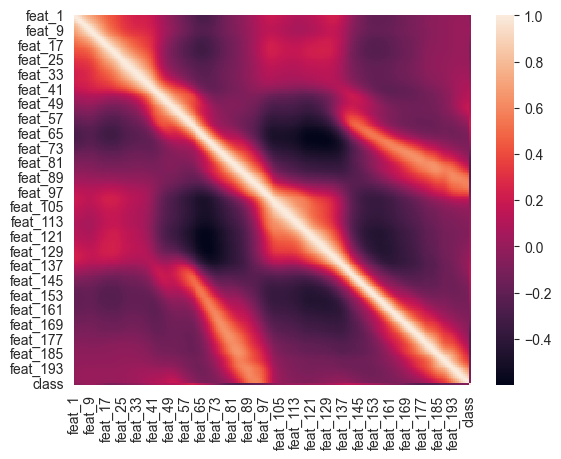

In [13]:
sns.heatmap(full_df.corr())

In [14]:
#full_df['class'] = np.where(full_df['class']=='UP', 1, 0)

In [15]:
cat_features = []

In [16]:
numeric_features = full_df.columns

In [17]:
# model_cicids = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
# param_grid = {"clf__n_estimators": [5], "clf__max_depth": [5]}

              precision    recall  f1-score   support

           1       0.99      0.44      0.61     28749
           2       1.00      0.96      0.98     28756
           3       0.41      1.00      0.58     11615

    accuracy                           0.75     69120
   macro avg       0.80      0.80      0.72     69120
weighted avg       0.90      0.75      0.76     69120

Accuracy: 0.7523292824074074


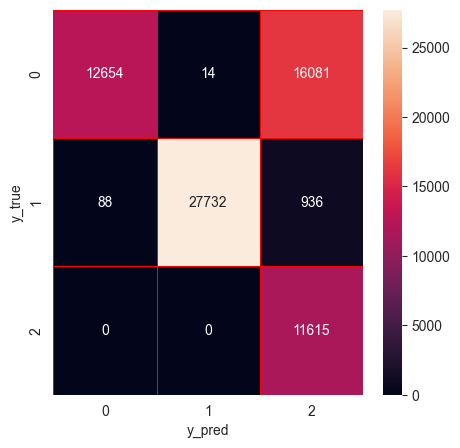

In [19]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

X = full_df.drop(['class'],axis=1)
y = full_df['class']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.2, test_size = 0.8, shuffle=False, random_state = 0)

# # LightGBM algorithm
import lightgbm as lgb
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy: "+ str(accuracy_score(y_test, y_pred)))

# Plot the confusion matrix
cm=confusion_matrix(y_test,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [20]:
top_feats_df = pd.DataFrame({'Value':model.feature_importances_,'Feature':X_train.columns.tolist()}).sort_values(by="Value",ascending=False)

In [21]:
top_feats_df

,Value,Feature
9,238,feat_10
19,223,feat_20
116,156,feat_117
113,134,feat_114
0,132,feat_1
...,...,...
168,12,feat_169
120,12,feat_121
180,11,feat_181
97,11,feat_98


In [76]:
top_feats = top_feats_df.Feature.tolist() #top_feats = top_feats_df.Feature.tolist() #

In [77]:
full_df_reduced = full_df[top_feats]

In [78]:
column_mapping_adult = {
    "target": "class",
    "numerical_features": full_df_reduced.columns,
    "categorical_features": [],
}

In [79]:
CT_dataset = Dataset(
    full_df=full_df_reduced, column_mapping=column_mapping_adult, window_size=1500 * 2, reference_size=1000
)

D:\Dokumentumok\BME\PhD\codes\dde\test_harness\datasets\dataset.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.reference_df['period'] = 'reference'
D:\Dokumentumok\BME\PhD\codes\dde\test_harness\datasets\dataset.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.reference_df['sample_num'] = self.reference_df.index
D:\Dokumentumok\BME\PhD\codes\dde\test_harness\datasets\dataset.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

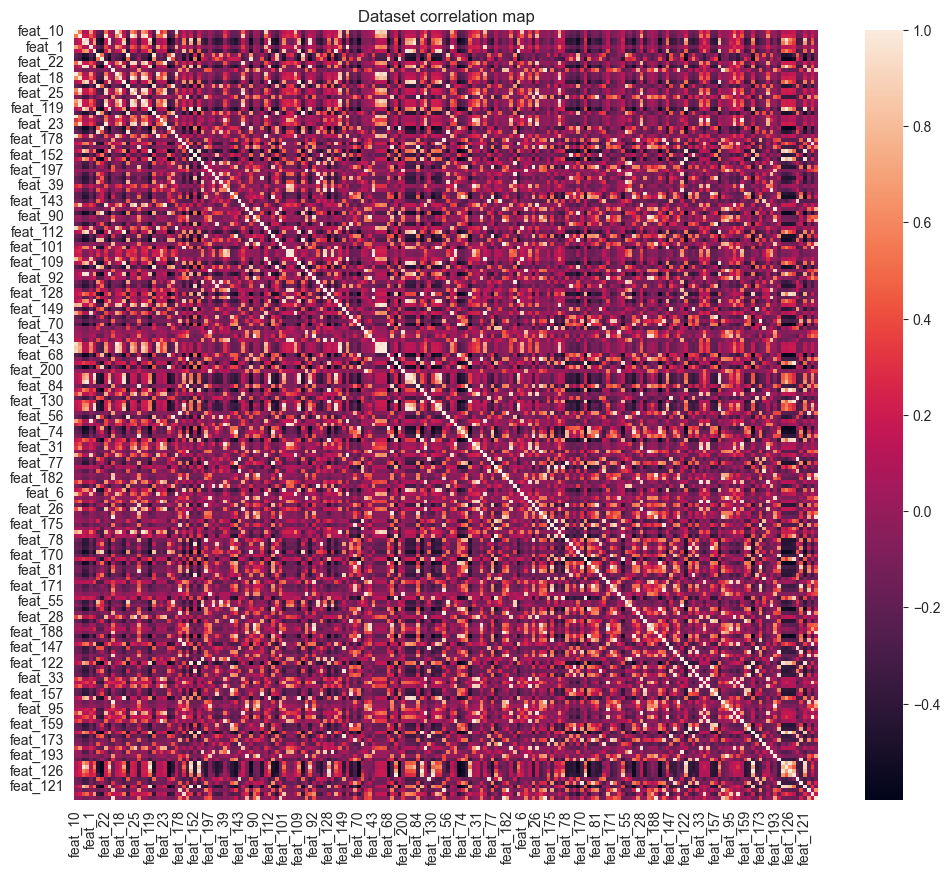

In [80]:
plt.figure(figsize=(12,10))
sns.heatmap(CT_dataset.full_df.corr(), annot=False)

plt.title('Dataset correlation map')
plt.show()

## Run Experiments

In [81]:
def windowed_correlation(df, mode='expanding'):
    corr_dict = {}
    columns = df.columns
    n = len(columns)
    for i in range(n):
        for j in range(i+1, n):
            col1 = columns[i]
            col2 = columns[j]
            key = (col1, col2)

            if mode=='expanding':
                corr_dict[key] = df[col1].expanding(10).corr(df[col2])
            else:
                corr_dict[key] = df[col1].rolling(window=10).corr(df[col2])

            corr_dict[key] = corr_dict[key].fillna(0)

    return corr_dict

In [82]:
def plot_windowed_correlation(corr_dict, vertical_lines=None):
    plt.figure(figsize=(15,10))
    for (col1, col2), corr in corr_dict.items():
        plt.plot(corr, label=f"{col1} vs {col2}")

    if vertical_lines:
        [plt.axvline(x, color='gray', linestyle='--') for x in vertical_lines if x != 0]

    plt.legend(bbox_to_anchor=(1, 0.5))
    labelLines(plt.gca().get_lines(), align=True)
    plt.show()

In [83]:
corr_dict = windowed_correlation(CT_dataset.full_df.loc[:, CT_dataset.full_df.columns], mode='expanding')

In [84]:
#plot_windowed_correlation(corr_dict)

In [85]:
column_names = list(CT_dataset.reference_df.columns)

In [86]:
calc = nml.UnivariateDriftCalculator(
    column_names=column_names,
    #timestamp_column_name='sample_num',
    continuous_methods=['jensen_shannon'],
    categorical_methods=['jensen_shannon'],
    #chunk_number=10,
    chunk_size=1000,
)

calc.fit(CT_dataset.reference_df)

D:\Dokumentumok\BME\PhD\codes\dde\venv\lib\site-packages\nannyml\chunk.py:181: UserWarning: The resulting number of chunks is too low. Please consider splitting your data in a different way or continue at your own risk.
  warnings.warn(
D:\Dokumentumok\BME\PhD\codes\dde\venv\lib\site-packages\scipy\spatial\distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


In [87]:
results = calc.calculate(CT_dataset.analysis_df)

In [88]:
results_js = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).to_df()
results_js.columns = ['_'.join(col) for col in results_js.columns.values]

,chunk_chunk_key,chunk_chunk_chunk_index,chunk_chunk_start_index,chunk_chunk_end_index,chunk_chunk_start_date,chunk_chunk_end_date,chunk_chunk_period,feat_10_jensen_shannon_value,feat_10_jensen_shannon_upper_threshold,feat_10_jensen_shannon_lower_threshold,...,feat_98_jensen_shannon_lower_threshold,feat_98_jensen_shannon_alert,feat_187_jensen_shannon_value,feat_187_jensen_shannon_upper_threshold,feat_187_jensen_shannon_lower_threshold,feat_187_jensen_shannon_alert,sample_num_jensen_shannon_value,sample_num_jensen_shannon_upper_threshold,sample_num_jensen_shannon_lower_threshold,sample_num_jensen_shannon_alert
0,[0:999],0,0,999,None,None,analysis,0.119930,0.1,None,...,None,False,0.079836,0.1,None,False,0.998009,0.1,None,True
1,[1000:1999],1,1000,1999,None,None,analysis,0.095154,0.1,None,...,None,True,0.087818,0.1,None,False,1.000000,0.1,None,True
2,[2000:2999],2,2000,2999,None,None,analysis,0.113840,0.1,None,...,None,False,0.097518,0.1,None,False,1.000000,0.1,None,True
3,[3000:3999],3,3000,3999,None,None,analysis,0.064817,0.1,None,...,None,False,0.052583,0.1,None,False,1.000000,0.1,None,True
4,[4000:4999],4,4000,4999,None,None,analysis,0.101772,0.1,None,...,None,False,0.074310,0.1,None,False,1.000000,0.1,None,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,[80000:80999],80,80000,80999,None,None,analysis,0.120648,0.1,None,...,None,True,0.093368,0.1,None,False,1.000000,0.1,None,True
81,[81000:81999],81,81000,81999,None,None,analysis,0.094755,0.1,None,...,None,False,0.070363,0.1,None,False,1.000000,0.1,None,True
82,[82000:82999],82,82000,82999,None,None,analysis,0.089608,0.1,None,...,None,False,0.053373,0.1,None,False,1.000000,0.1,None,True
83,[83000:83999],83,83000,83999,None,None,analysis,0.098826,0.1,None,...,None,False,0.100700,0.1,None,True,1.000000,0.1,None,True


In [90]:
display(results_js.iloc[18:21])

,chunk_chunk_key,chunk_chunk_chunk_index,chunk_chunk_start_index,chunk_chunk_end_index,chunk_chunk_start_date,chunk_chunk_end_date,chunk_chunk_period,feat_10_jensen_shannon_value,feat_10_jensen_shannon_upper_threshold,feat_10_jensen_shannon_lower_threshold,...,feat_98_jensen_shannon_lower_threshold,feat_98_jensen_shannon_alert,feat_187_jensen_shannon_value,feat_187_jensen_shannon_upper_threshold,feat_187_jensen_shannon_lower_threshold,feat_187_jensen_shannon_alert,sample_num_jensen_shannon_value,sample_num_jensen_shannon_upper_threshold,sample_num_jensen_shannon_lower_threshold,sample_num_jensen_shannon_alert
18,[18000:18999],18,18000,18999,None,None,analysis,0.097670,0.1,None,...,None,True,0.106058,0.1,None,True,1.0,0.1,None,True
19,[19000:19999],19,19000,19999,None,None,analysis,0.139286,0.1,None,...,None,True,0.081814,0.1,None,False,1.0,0.1,None,True
20,[20000:20999],20,20000,20999,None,None,analysis,0.166604,0.1,None,...,None,True,0.157328,0.1,None,True,1.0,0.1,None,True


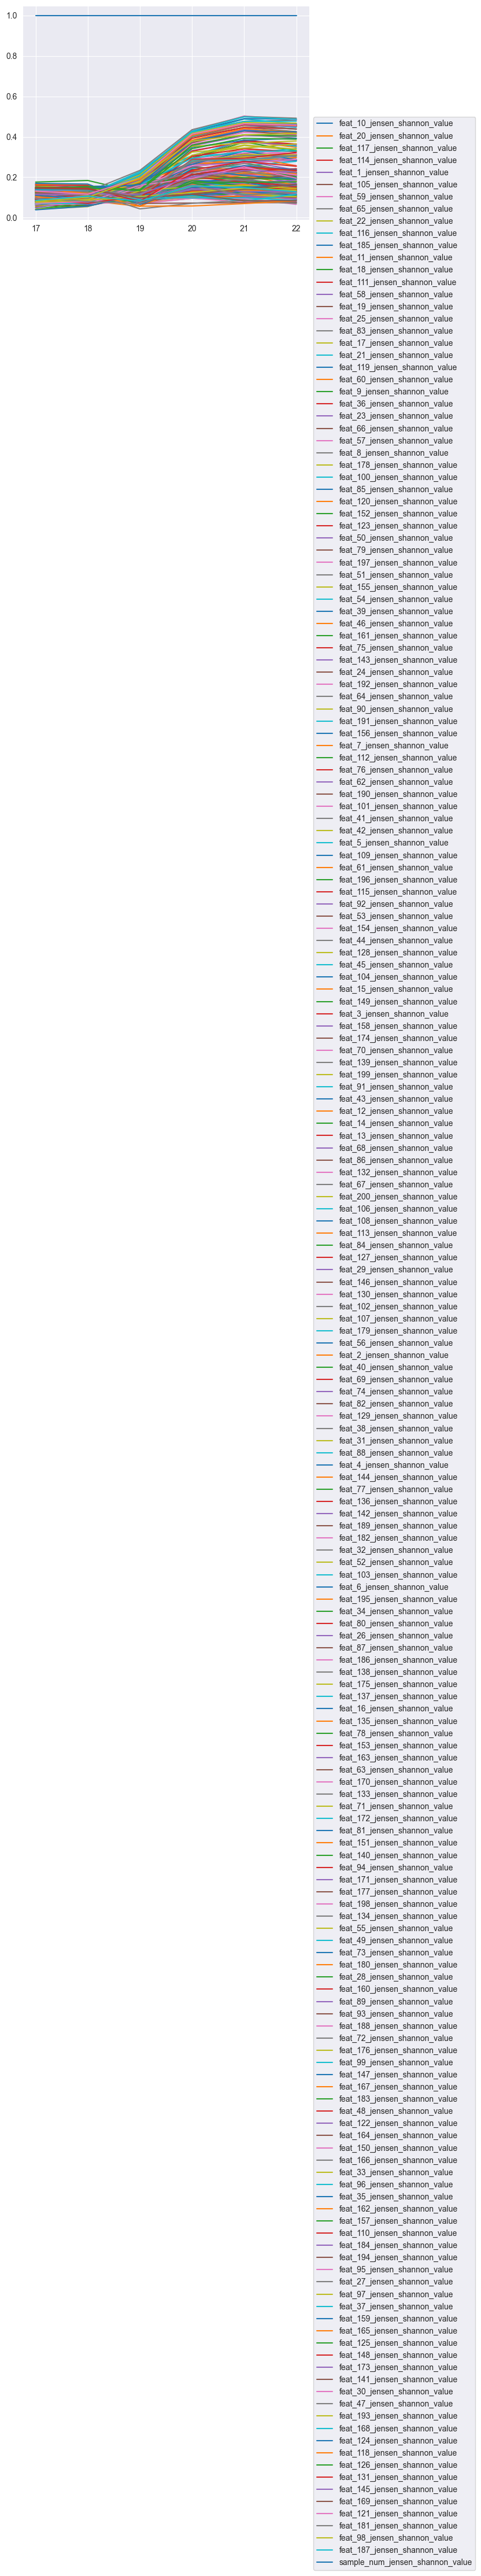

In [143]:
results_js[[col for col in results_js.columns if '_jensen_shannon_value' in col]].iloc[19-2:19+4].plot()
plt.legend(bbox_to_anchor=(1, 0.5))

In [55]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='drift')
# figure.show()

In [56]:
# figure = results.filter(column_names=results.continuous_column_names, methods=['jensen_shannon']).plot(kind='distribution')
# figure.show()

### Own Jensen-Shannon

In [105]:
chg_points = [19000, 76000]

In [106]:
CT_dataset.add_changepoints(chg_points)

In [144]:
rad_left = 1000
rad_right = 5000

In [145]:
dde_exp_eq_radius = DDEffectExperiment(_dataset=CT_dataset)
dde_exp_eq_radius.changepoint_radius_driftscore(radius_left=rad_left, radius_right=rad_right)
display(dde_exp_eq_radius.results_all)

18000 19000 24000


D:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['period'] = 'reference'
D:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['sample_num'] = ref_df.index
D:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

75000 76000 81000


D:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['period'] = 'reference'
D:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ref_df['sample_num'] = ref_df.index
D:\Dokumentumok\BME\PhD\codes\dde\test_harness\experiments\dde_experiment.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,start,change_point,end,feat_10,feat_20,feat_117,feat_114,feat_1,feat_105,feat_59,...,feat_118,feat_126,feat_131,feat_145,feat_169,feat_121,feat_181,feat_98,feat_187,sample_num
0,18000,19000,20000,0.152958,0.251419,0.353334,0.348899,0.177511,0.365164,0.194508,...,0.355975,0.339147,0.266501,0.086753,0.109217,0.357563,0.074522,0.261078,0.093758,0.999486
1,75000,76000,77000,0.089142,0.157630,0.190936,0.181165,0.089967,0.181177,0.165514,...,0.188870,0.169573,0.153215,0.084466,0.111195,0.178264,0.112487,0.095118,0.097446,0.999486


In [146]:
dde_exp_eq_radius.changepoint_radius_corr(radius_left=rad_left, radius_right=rad_right)

18000 19000 24000
75000 76000 81000


#### Change point 1

In [153]:
with pd.ExcelWriter(f'outputs/insects/CD_delta_vs_ro_chp_tabs.xlsx') as writer:

    for chp in CT_dataset.change_points[:1]:
        drift_threshold = 0.25
        summary_df = pd.DataFrame(columns=['feat_1', 'feat_2', 'ref_corr', 'analysis_corr', 'corr_delta', 'feat_1_cd_score', 'feat_2_cd_score', 'delta_cd_score'])

        corr_df_delta = dde_exp_eq_radius.corr_scores[chp]['corr_delta']
        corr_df_analysis = dde_exp_eq_radius.corr_scores[chp]['analysis']
        corr_df_ref = dde_exp_eq_radius.corr_scores[chp]['reference']

        cd_score_df = dde_exp_eq_radius.results_all.loc[dde_exp_eq_radius.results_all['change_point']==chp].iloc[0]

        for pair in itertools.combinations(dde_exp_eq_radius.dataset.full_df.columns, 2):
            feat1 = list(pair)[0]
            feat2 = list(pair)[1]

            summary_df.loc[len(summary_df.index)] = [feat1, feat2, np.abs(corr_df_ref.loc[feat1, feat2]), np.abs(corr_df_analysis.loc[feat1, feat2]), corr_df_delta.loc[feat1, feat2], cd_score_df[feat1], cd_score_df[feat2], np.abs(cd_score_df[feat1]-cd_score_df[feat2])]

        summary_df['feat_1_drift'] = np.where(summary_df['feat_1_cd_score']>drift_threshold, 1, 0)
        summary_df['feat_2_drift'] = np.where(summary_df['feat_2_cd_score']>drift_threshold, 1, 0)
        summary_df['single_feat_drift'] = np.where(summary_df['feat_1_drift'] ^ summary_df['feat_2_drift'], 1, 0)
        summary_df['feat_pair_drift'] = np.where(summary_df['feat_1_drift'] & summary_df['feat_2_drift'], 1, 0)

        summary_df.to_excel(writer, sheet_name=f'{chp}', index=False)

In [154]:
summary_df = summary_df.sort_values(by=['feat_1_cd_score'], ascending=False)

In [155]:
summary_df

,feat_1,feat_2,ref_corr,analysis_corr,corr_delta,feat_1_cd_score,feat_2_cd_score,delta_cd_score,feat_1_drift,feat_2_drift,single_feat_drift,feat_pair_drift
14752,feat_107,feat_40,0.193415,0.028659,0.222074,0.368992,0.067681,0.301312,1,0,1,0
14820,feat_107,feat_35,0.182420,0.088831,0.093589,0.368992,0.089714,0.279279,1,0,1,0
14818,feat_107,feat_33,0.229712,0.109924,0.119788,0.368992,0.112546,0.256446,1,0,1,0
14817,feat_107,feat_166,0.080570,0.266515,0.185945,0.368992,0.129590,0.239403,1,0,1,0
14816,feat_107,feat_150,0.166221,0.329028,0.162807,0.368992,0.148724,0.220269,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15231,feat_40,feat_47,0.442872,0.606065,0.163194,0.067681,0.135832,0.068151,0,0,0,0
15232,feat_40,feat_193,0.052906,0.030562,0.022344,0.067681,0.101967,0.034286,0,0,0,0
15233,feat_40,feat_168,0.190409,0.194060,0.003650,0.067681,0.118405,0.050724,0,0,0,0
15234,feat_40,feat_124,0.135761,0.022089,0.157850,0.067681,0.352231,0.284550,0,1,1,0


In [156]:
summary_df.feat_1_drift.sum()

5490

In [157]:
def get_roc_auc(scores, ys):
    # false positive rate
    FPR = []
    # true positive rate
    TPR = []
    # Iterate thresholds from 0.0 to 1.0
    thresholds = np.arange(0.0, 1.01, 0.2)
    # array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

    # get number of positive and negative examples in the dataset
    P = sum(y)
    N = len(y) - P

    # iterate through all thresholds and determine fraction of true positives
    # and false positives found at this threshold
    for thresh in thresholds:
        FP=0
        TP=0
        thresh = round(thresh,2) #Limiting floats to two decimal points, or threshold 0.6 will be 0.6000000000000001 which gives FP=0
        for i in range(len(score)):
            if (score[i] >= thresh):
                if y[i] == 1:
                    TP = TP + 1
                if y[i] == 0:
                    FP = FP + 1
        FPR.append(FP/N)
        TPR.append(TP/P)

    auc = -1 * np.trapz(TPR, FPR)

    plt.plot(FPR, TPR, linestyle='--', marker='o', color='darkorange', lw = 2, label='ROC curve', clip_on=False)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, AUC = %.2f'%auc)
    plt.legend(loc="lower right")
    plt.savefig('AUC_example.png')
    plt.show()

In [158]:
def plot_lift_curve(y_pred, y_val, step=0.01):

    #Define an auxiliar dataframe to plot the curve
    aux_lift = pd.DataFrame()
    #Create a real and predicted column for our new DataFrame and assign values
    aux_lift['real'] = y_val
    aux_lift['predicted'] = y_pred
    #Order the values for the predicted probability column:
    aux_lift.sort_values('predicted',ascending=False,inplace=True)

    #Create the values that will go into the X axis of our plot
    x_val = np.arange(step,1+step,step)
    #Calculate the ratio of ones in our data
    ratio_ones = aux_lift['real'].sum() / len(aux_lift)
    #Create an empty vector with the values that will go on the Y axis our our plot
    y_v = []

    #Calculate for each x value its correspondent y value
    for x in x_val:
        num_data = int(np.ceil(x*len(aux_lift))) #The ceil function returns the closest integer bigger than our number
        data_here = aux_lift.iloc[:num_data,:]   # ie. np.ceil(1.4) = 2
        ratio_ones_here = data_here['real'].sum()/len(data_here)
        y_v.append(ratio_ones_here / ratio_ones)

   #Plot the figure
    fig, axis = plt.subplots()
    fig.figsize = (40,40)
    axis.plot(x_val, y_v, 'g-', linewidth = 3, markersize = 5)
    axis.plot(x_val, np.ones(len(x_val)), 'k-')
    axis.set_xlabel('Proportion of sample')
    axis.set_ylabel('Lift')
    plt.title('Lift Curve')
    plt.show()

In [159]:
score = summary_df.ref_corr #np.array([0.8, 0.6, 0.4, 0.2])
y = summary_df.feat_pair_drift #np.array([1,0,1,0])

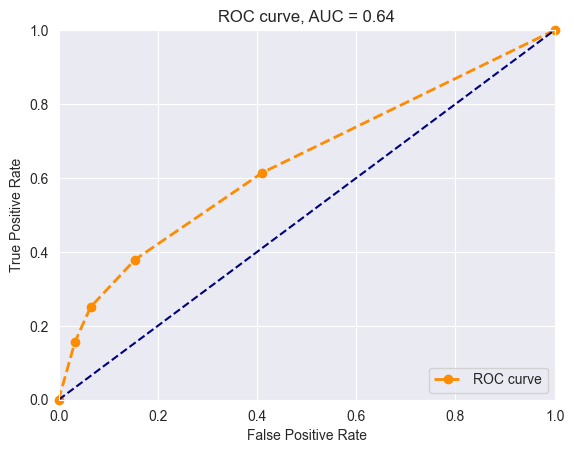

In [160]:
get_roc_auc(score, y)

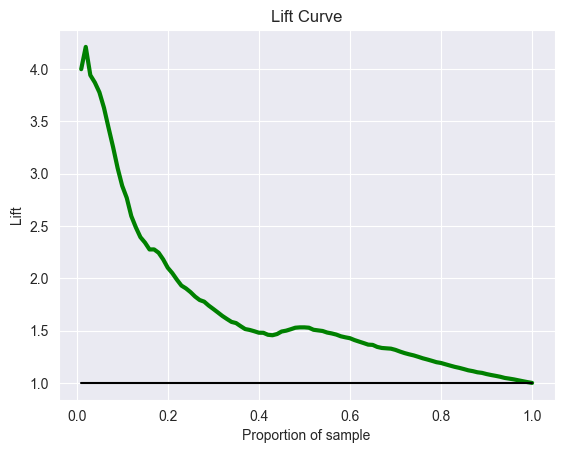

In [161]:
plot_lift_curve(score, y)